#Load requirements and data

In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import matplotlib.pyplot as plt
import subprocess

In [2]:
df = pd.read_excel('https://github.com/armanheydari/my-datas/blob/master/TIMSS2019.xlsx?raw=true')

#Pre-processing

first, we try to remove redundant students.

if there is one, we keep the last record of him/her.

In [52]:
pre_processed_df = df.drop_duplicates(subset=['IDSTUD'], keep='last')

second, we check everyone to be iranian:

In [53]:
pre_processed_df = pre_processed_df.query('IDCNTRY==364')

In [54]:
pre_processed_df = pre_processed_df.replace(['A', 'B', 'C', 'D', 'E'], [5, 4, 3, 2, 1])

##Unneccessary columns

In [55]:
pre_processed_df.nunique().sort_values(ascending=False)

IDSTUD      5980
BSBGSB       308
BSBGSCM      230
IDSCHOOL     220
IDCLASS      220
            ... 
BTBG05H        2
ITSEX          2
IDCNTRY        1
BSDGSEC        0
BSBGSEC        0
Length: 338, dtype: int64

In [56]:
pre_processed_df = pre_processed_df.drop(columns=['IDSTUD', 'IDCNTRY', 'IDSCHOOL', 'IDCLASS', 'IDBOOK', 'totalscore', 'BSBGSEC', 'BSDGSEC'])
pre_processed_df.nunique().sort_values(ascending=False)

BSBGSB     308
BSBGSCM    230
BSBGSLM    210
BSBGSVM    138
BSBGICM    108
          ... 
BTBG02       2
BTBG05H      2
BTBG05G      2
BCBG09       2
BSBG01       2
Length: 330, dtype: int64

In [57]:
correlation = pre_processed_df.corr()
eliminated_list = []
for c in correlation.columns:
  if c not in (['finalscore', 'finalscorealgebra', 'finalscoredat',	'finalscoregeo', 'finalscorenum'] + eliminated_list):
    temp = correlation[c]
    temp = temp[abs(temp) >= 0.6]
    temp = temp[temp.index != c]
    for eliminate_column in list(temp.index):
      if eliminate_column not in eliminated_list:
        eliminated_list.append(eliminate_column)

pre_processed_df = pre_processed_df.drop(columns=eliminated_list)

##null values

here we can see how many times each column is null.

In [58]:
null_columns=pre_processed_df.columns[pre_processed_df.isna().any()]
pre_processed_df[null_columns].isna().sum().sort_values(ascending=False)

finalscoredat        30
finalscoregeo        25
finalscorealgebra    18
finalscorenum         7
finalscore            5
                     ..
BSBG13B               1
BSBG13A               1
BSBG12F               1
BSBG12E               1
BSDGEDUP              1
Length: 103, dtype: int64

scores are very important for our analysis. so if we have a record with null final score in each concept, we have to drop that record.

In [59]:
pre_processed_df.loc[pre_processed_df['finalscore'].isna(), ['finalscore',	'finalscorealgebra', 'finalscoredat',	'finalscoregeo', 'finalscorenum']]

,finalscore,finalscorealgebra,finalscoredat,finalscoregeo,finalscorenum
746,NaN,NaN,NaN,NaN,NaN
3003,NaN,NaN,NaN,NaN,NaN
3044,NaN,NaN,NaN,NaN,NaN
3980,NaN,NaN,NaN,NaN,NaN
4888,NaN,NaN,NaN,NaN,NaN


In [60]:
pre_processed_df = pre_processed_df.dropna(subset=['finalscore', 'finalscorealgebra', 'finalscoredat',	'finalscoregeo', 'finalscorenum'])

now we check again to see which columns of how many rows are includes null values:

In [61]:
print(pre_processed_df[pre_processed_df.isna().any(axis=1)])
null_columns=pre_processed_df.columns[pre_processed_df.isna().any()]
print(pre_processed_df[null_columns].isna().sum().sort_values(ascending=False))

      finalscore  finalscorealgebra  finalscoredat  finalscoregeo  \
2995         1.0                1.0            1.0            1.0   
3300         1.0                1.0            2.0            1.0   

      finalscorenum  BSBG01  BSBG03  BSBG04  BSBG05A  BSBG05B  ...  BTBM22AA  \
2995            1.0     NaN     NaN     NaN      NaN      NaN  ...         2   
3300            1.0     2.0     2.0     2.0      1.0      2.0  ...         2   

      BTBM22BA  BTBM22AB  BTBM22AC  BTBM22AD  BTBM22AE  BTBM22AF  BTBM22AG  \
2995         1         2         2         2         1         1         2   
3300         1         2         1         1         1         1         2   

      BTBM23  BTDGLSN  
2995       3        2  
3300       5        2  

[2 rows x 247 columns]
BSBG06A     2
BSBM17G     1
BSBM19D     1
BSBM19C     1
BSBM19B     1
           ..
BSBG13D     1
BSBG13C     1
BSBG13B     1
BSBG13A     1
BSDGEDUP    1
Length: 98, dtype: int64


so we drop the last 2 rows:

In [62]:
pre_processed_df = pre_processed_df.dropna()

## ommitted data

In [65]:
ommited_list = []
for feature_name in pre_processed_df.columns:
   ommited_list.append((feature_name, len(pre_processed_df[pre_processed_df[feature_name]==9])))

ommited_list.sort(key = lambda x: x[1]) 
ommited_list

[('finalscore', 0),
 ('finalscorealgebra', 0),
 ('finalscoredat', 0),
 ('finalscoregeo', 0),
 ('finalscorenum', 0),
 ('BSBG01', 0),
 ('BSDAGE', 0),
 ('BSBGHER', 0),
 ('BSBGSSB', 0),
 ('BSBGSB', 0),
 ('BSBGSLM', 0),
 ('BSBGSCM', 0),
 ('BSBGSVM', 0),
 ('BCBG04', 0),
 ('BCBG05A', 0),
 ('BCBG05B', 0),
 ('BCBG06A', 0),
 ('BCBG06B', 0),
 ('BCBG06C', 0),
 ('BCBG09', 0),
 ('BCBG10A', 0),
 ('BCBG12', 0),
 ('BCBG13AA', 0),
 ('BCBG13AG', 0),
 ('BCBG13BC', 0),
 ('BCBG14A', 0),
 ('BCBG14C', 0),
 ('BCBG14G', 0),
 ('BCBG14I', 0),
 ('BCBG14K', 0),
 ('BCBG15A', 0),
 ('BCBG15C', 0),
 ('BCBG15D', 0),
 ('BCBG15G', 0),
 ('BCBG15H', 0),
 ('BCBG16C', 0),
 ('BCBG17A', 0),
 ('BCBG20', 0),
 ('BCDGMRS', 0),
 ('BTBG04', 0),
 ('BTBG05F', 0),
 ('BTBG05G', 0),
 ('BTBG05H', 0),
 ('BTBG07A', 0),
 ('BTBG07B', 0),
 ('BTBG07D', 0),
 ('BTBG07G', 0),
 ('BTBG08A', 0),
 ('BTBG08B', 0),
 ('BTBG08D', 0),
 ('BTBG08E', 0),
 ('BTBG09F', 0),
 ('BTBG09G', 0),
 ('BTBG09H', 0),
 ('BTBG11', 0),
 ('BTBG13A', 0),
 ('BTBG13B', 0),
 ('BTB

In [67]:
pre_processed_df = pre_processed_df.drop(columns=['BSBM27AA', 'BCBG21B'])

# Normalization

In [68]:
def z_score(df):
    df_std = df.copy()
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        
    return df_std

In [69]:
def min_max(df):
  normalized_df = df.copy()
  for feature_name in normalized_df.columns:
    max_value = normalized_df[feature_name].max()
    min_value = normalized_df[feature_name].min()
    if max_value == min_value:
      normalized_df[feature_name] = 0  
    else:
      normalized_df[feature_name] = (normalized_df[feature_name] - min_value) / (max_value - min_value)
  return normalized_df

# Desicion tree

In [70]:
def visualize_tree(tree, feature_names):
  with open("dt.dot", 'w') as f:
      export_graphviz(tree, out_file=f,
                      feature_names=feature_names)

  command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
  try:
      subprocess.check_call(command)
  except:
      exit("Could not run dot, ie graphviz, to "
            "produce visualization")

In [71]:
def desicion_tree(dataframe, target_column, unnecessary_columns):
  temp = dataframe.nunique().sort_values(ascending=False)
  temp = temp[temp>8]
  not_unique_attributes = list(temp.keys())
  print("\nfeatures with more than 8 unique values:", not_unique_attributes)

  y = dataframe[target_column]
  X = dataframe.drop(columns = not_unique_attributes + [target_column]+ unnecessary_columns)
  print("\nafter remove extra features: \n", X.nunique().sort_values(ascending=False))

  dt = DecisionTreeClassifier()
  dt.fit(X, y)
  # visualize_tree(dt, X.columns)
  # print("\ntree schema saved on dt.png")

  print("\nthe most important features (features on top of the tree): ")
  best_attributes = pd.DataFrame(dt.feature_importances_, 
                                 index = X.columns, 
                                 columns=['importance']).sort_values('importance',
                                                                     ascending=False).head(30)
  print(best_attributes)
  return not_unique_attributes, list(best_attributes.index)

# Correlation

In [72]:
def correlation_analysis(dataframe, target_column):
  correlation_results = []
  for feature_name in dataframe.columns:
    if feature_name != target_column:
      temp = dataframe[[target_column, feature_name]]
      feature_max = max(temp[feature_name])
      if feature_max in [9, 99, 999, 9999, 99999, 999999]:
        temp = temp[temp[feature_name]<feature_max]
      temp = z_score(temp)
      correlation_results.append((feature_name, temp.corr()[target_column][feature_name]))

  correlation_results.sort(key = lambda x: x[1]) 
  return correlation_results

In [73]:
def plot_relation(dataframe, x, y):
  df = dataframe[[x, y]]
  feature_max = max(df[x])
  if feature_max in [9, 99, 999, 9999, 99999, 999999]:
    df = df[df[x]<feature_max]
  df = df.groupby(x).mean()
  print("\nthe relation between", y, "with", x,': ')
  df.plot(y = y, kind='line')
  plt.show()

#Run and answer

##A

In [74]:
pre_processed_df

,finalscore,finalscorealgebra,finalscoredat,finalscoregeo,finalscorenum,BSBG01,BSBG03,BSBG04,BSBG05A,BSBG05B,...,BTBM22AA,BTBM22BA,BTBM22AB,BTBM22AC,BTBM22AD,BTBM22AE,BTBM22AF,BTBM22AG,BTBM23,BTDGLSN
0,2.0,5.0,2.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,...,1,1,2,2,2,1,1,2,5,2
1,2.0,2.0,2.0,1.0,2.0,1.0,1.0,3.0,1.0,1.0,...,1,1,2,2,2,1,1,2,5,2
2,4.0,4.0,2.0,3.0,4.0,1.0,1.0,4.0,1.0,1.0,...,1,1,2,2,2,1,1,2,5,2
3,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,...,2,2,2,2,2,2,2,2,4,2
4,2.0,2.0,3.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,...,2,2,2,2,2,2,2,2,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5975,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2,1,2,2,1,2,2,2,2,3
5976,2.0,1.0,1.0,3.0,1.0,1.0,4.0,1.0,2.0,1.0,...,1,2,1,1,1,1,1,1,5,2
5977,1.0,1.0,1.0,2.0,1.0,1.0,3.0,2.0,1.0,2.0,...,1,2,1,1,1,1,1,1,5,2
5978,2.0,1.0,1.0,3.0,1.0,2.0,1.0,5.0,1.0,1.0,...,1,2,1,2,2,1,1,1,4,3


In [75]:
not_unique_attributes, best_attributes = desicion_tree(pre_processed_df,
                                                       'finalscore',
                                                       ['finalscorealgebra', 'finalscoredat',	'finalscoregeo', 'finalscorenum']
                                                       )


features with more than 8 unique values: ['BSBGSB', 'BSBGSCM', 'BSBGSLM', 'BSBGSVM', 'BSBGSSB', 'BSDAGE', 'BCBG06A', 'BTBG01', 'BSBGHER', 'BCBG18', 'BCBG06B', 'BTBM14', 'BCBG07', 'BTBG11', 'BSBG06B', 'BSBG06A']

after remove extra features: 
 BCBG05A     8
BSBM26BA    7
BSDGEDUP    7
BSBG07      7
BTBM19B     7
           ..
BCBG12      2
BTBG05F     2
BTBG05G     2
BTBG05H     2
BSBG01      2
Length: 224, dtype: int64

the most important features (features on top of the tree): 
          importance
BSBG07      0.038508
BSBM19B     0.029113
BSBG04      0.020913
BSBM15      0.017810
BSDGEDUP    0.016298
BSBM19H     0.015180
BCBG05B     0.014188
BSBM26BA    0.013730
BSBG13C     0.013663
BCBG14H     0.013575
BSBM19F     0.013557
BSBG13E     0.013065
BSBG10      0.012604
BSBM26AA    0.012447
BSBG11B     0.011012
BSBG11A     0.010917
BSBM18D     0.010714
BSBG14C     0.010714
BSBM19G     0.010584
BSBM16B     0.009610
BSBG14D     0.009607
BSBG13D     0.009393
BSBM19C     0.009294
BSBM18F    

In [76]:
A_df = pre_processed_df[['finalscore'] + best_attributes + not_unique_attributes]
A_df

,finalscore,BSBG07,BSBM19B,BSBG04,BSBM15,BSDGEDUP,BSBM19H,BCBG05B,BSBM26BA,BSBG13C,...,BCBG06A,BTBG01,BSBGHER,BCBG18,BCBG06B,BTBM14,BCBG07,BTBG11,BSBG06B,BSBG06A
0,2.0,5.0,2.0,3.0,4.0,2.0,3.0,1,6.0,3.0,...,170,27,10.23835,20,270,90,3,0,4.0,4.0
1,2.0,4.0,3.0,3.0,2.0,1.0,1.0,1,4.0,4.0,...,170,27,11.48712,20,270,90,3,0,7.0,6.0
2,4.0,6.0,4.0,4.0,1.0,1.0,4.0,1,3.0,4.0,...,170,27,12.25657,20,270,90,3,0,6.0,7.0
3,1.0,6.0,2.0,2.0,3.0,4.0,1.0,2,4.0,1.0,...,160,15,8.35810,1,210,240,0,5,2.0,1.0
4,2.0,3.0,1.0,2.0,3.0,3.0,4.0,2,3.0,4.0,...,160,15,9.03613,1,210,240,0,5,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5975,2.0,4.0,3.0,2.0,3.0,3.0,3.0,4,3.0,2.0,...,149,27,9.64761,9,270,90,1,1,3.0,3.0
5976,2.0,3.0,3.0,1.0,3.0,5.0,1.0,4,3.0,1.0,...,142,1,7.56439,5,250,180,0,0,1.0,1.0
5977,1.0,6.0,3.0,2.0,3.0,2.0,1.0,4,2.0,2.0,...,142,1,9.03613,5,250,180,0,0,5.0,2.0
5978,2.0,6.0,4.0,5.0,4.0,1.0,1.0,3,6.0,1.0,...,170,26,13.51543,1,270,180,7,15,5.0,6.0


In [77]:
correlation_analysis(A_df, 'finalscore')

[('BSDGEDUP', -0.3326660695788252),
 ('BCBG14H', -0.2850018175583022),
 ('BCBG05B', -0.27218267214512043),
 ('BSBM19F', -0.2576769528568183),
 ('BSBM19G', -0.25701648333164256),
 ('BSBM15', -0.21303178097520667),
 ('BSBM16H', -0.1202182708275955),
 ('BSBM20G', -0.10555519983281525),
 ('BSBM17C', -0.10225263730235143),
 ('BSDAGE', -0.10218872222579273),
 ('BSBG13E', -0.0982732434932951),
 ('BTBG11', -0.09214366192999246),
 ('BSBG13D', 0.00343318663332102),
 ('BSBG13B', 0.014390074896699414),
 ('BSBG13C', 0.021388351170022215),
 ('BSBG11A', 0.024586407149019034),
 ('BSBM26AA', 0.02905765925957637),
 ('BSBGSSB', 0.029466043340394953),
 ('BSBG14C', 0.044859038184609186),
 ('BSBG11B', 0.08389415004617268),
 ('BSBM18F', 0.08594176282531692),
 ('BSBG14F', 0.08874807639255437),
 ('BTBG01', 0.08931340303185353),
 ('BSBGSB', 0.09503057332820554),
 ('BSBM18D', 0.09997385545379878),
 ('BCBG06A', 0.10029319943704622),
 ('BSBG14D', 0.1116214466376256),
 ('BCBG18', 0.11499397902003339),
 ('BSBGSVM', 


the relation between finalscore with BSDGEDUP : 


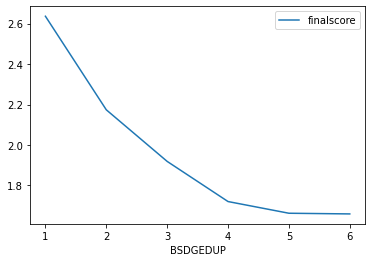


the relation between finalscore with BSBGHER : 


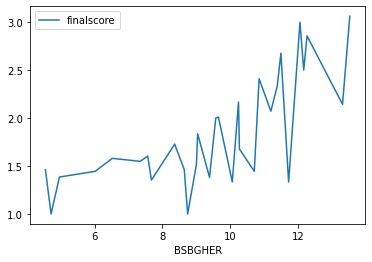


the relation between finalscore with BSBGSCM : 


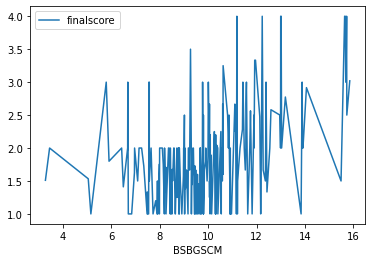

In [79]:
plot_relation(pre_processed_df, 'BSDGEDUP', 'finalscore')
plot_relation(pre_processed_df, 'BSBGHER', 'finalscore')
plot_relation(pre_processed_df, 'BSBGSCM', 'finalscore')

## B

###male

In [80]:
B_male_df = pre_processed_df[pre_processed_df['BSBG01']==2]
B_male_df

,finalscore,finalscorealgebra,finalscoredat,finalscoregeo,finalscorenum,BSBG01,BSBG03,BSBG04,BSBG05A,BSBG05B,...,BTBM22AA,BTBM22BA,BTBM22AB,BTBM22AC,BTBM22AD,BTBM22AE,BTBM22AF,BTBM22AG,BTBM23,BTDGLSN
5,1.0,2.0,2.0,1.0,1.0,2.0,4.0,3.0,2.0,2.0,...,2,1,2,2,2,1,2,2,2,1
6,1.0,1.0,2.0,1.0,1.0,2.0,4.0,2.0,1.0,1.0,...,2,1,2,2,2,1,1,2,3,2
7,2.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,...,2,1,2,2,2,1,1,2,3,2
11,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,...,2,1,2,2,1,2,2,2,4,1
12,2.0,2.0,1.0,1.0,2.0,2.0,3.0,3.0,1.0,2.0,...,2,1,2,2,1,2,2,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,4.0,4.0,3.0,3.0,2.0,2.0,1.0,2.0,1.0,2.0,...,1,1,2,1,2,1,2,2,2,2
5972,3.0,3.0,2.0,4.0,2.0,2.0,1.0,3.0,1.0,1.0,...,1,1,2,1,2,1,2,2,2,2
5975,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2,1,2,2,1,2,2,2,2,3
5978,2.0,1.0,1.0,3.0,1.0,2.0,1.0,5.0,1.0,1.0,...,1,2,1,2,2,1,1,1,4,3


In [81]:
not_unique_attributes, best_attributes = desicion_tree(B_male_df,
                                                       'finalscore',
                                                       ['finalscorealgebra', 'finalscoredat',	'finalscoregeo', 'finalscorenum']
                                                       )

B_male_df = B_male_df[['finalscore'] + best_attributes + not_unique_attributes]


features with more than 8 unique values: ['BSBGSB', 'BSBGSCM', 'BSBGSLM', 'BSBGSVM', 'BSBGSSB', 'BSDAGE', 'BCBG06A', 'BTBG01', 'BSBGHER', 'BCBG18', 'BTBM14', 'BCBG06B', 'BTBG11', 'BCBG07', 'BSBG06A', 'BSBG06B']

after remove extra features: 
 BCBG05A     8
BSBG07      7
BSBM26BA    7
BSDGEDUP    7
BTBM19B     6
           ..
BTBG05G     2
BTBM18BF    2
BTBG05H     2
BTBM17A     2
BSBG01      1
Length: 224, dtype: int64

the most important features (features on top of the tree): 
          importance
BSBG07      0.043939
BSBM19B     0.022624
BCBG05A     0.022031
BSBM15      0.019442
BCBG14H     0.017262
BSDGEDUP    0.016693
BSBM26BA    0.015920
BSBG13D     0.015786
BSBM18F     0.015378
BSBM19H     0.014192
BSBM19F     0.013564
BSBG13C     0.013435
BSBG04      0.013149
BSBM16G     0.013026
BSBM19D     0.012894
BSBM18C     0.012438
BSBG11B     0.011620
BSBG14D     0.011600
BSBM18E     0.011554
BSBG13B     0.011225
BSBM17C     0.011075
BSBM19C     0.010920
BCBG13AD    0.010917
BSBM16C    

In [82]:
correlation_analysis(B_male_df, 'finalscore')

[('BCBG14H', -0.3475942868383596),
 ('BSDGEDUP', -0.34746214900178035),
 ('BCBG05A', -0.3228880664879857),
 ('BSBM19D', -0.2841205602827857),
 ('BSBM19A', -0.23926525612549196),
 ('BSBM15', -0.22713296419672016),
 ('BSBM19F', -0.2256759368378357),
 ('BSBG03', -0.19192601689990058),
 ('BSBM16G', -0.18623503852072307),
 ('BTBG11', -0.13972479045688357),
 ('BCBG13AD', -0.12313679949469222),
 ('BSDAGE', -0.12257748739552339),
 ('BSBM17C', -0.09347038751575526),
 ('BSBM20E', -0.08707890625027247),
 ('BSBG13C', 0.007296239461487775),
 ('BSBG13D', 0.014362352640934528),
 ('BSBG13B', 0.020859984396579205),
 ('BTBG01', 0.03210475741029761),
 ('BSBGSSB', 0.0484784403713863),
 ('BSBM18E', 0.0781415747653475),
 ('BCBG18', 0.0813228593775332),
 ('BSBM18F', 0.08892230391309516),
 ('BSBG11B', 0.09030037282531388),
 ('BSBM18C', 0.0905190080647999),
 ('BSBG14F', 0.09887131133001109),
 ('BSBGSVM', 0.11098752991700908),
 ('BSBGSB', 0.11772967728379799),
 ('BSBG14M', 0.12415916569451278),
 ('BSBG14D', 0.1


the relation between finalscore with BSBGHER : 


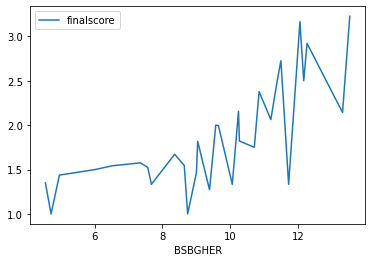


the relation between finalscore with BSBGSCM : 


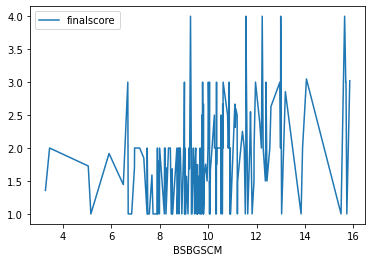


the relation between finalscore with BSBG04 : 


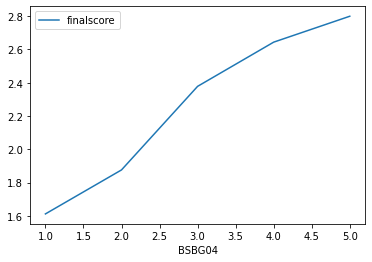

In [85]:
plot_relation(B_male_df, 'BSBGHER', 'finalscore')
plot_relation(B_male_df, 'BSBGSCM', 'finalscore')
plot_relation(B_male_df, 'BSBG04', 'finalscore')

###female

In [83]:
B_female_df = pre_processed_df[pre_processed_df['BSBG01']==1]

not_unique_attributes, best_attributes = desicion_tree(B_female_df,
                                                       'finalscore',
                                                       ['finalscorealgebra', 'finalscoredat',	'finalscoregeo', 'finalscorenum']
                                                       )

B_female_df = B_female_df[['finalscore'] + best_attributes + not_unique_attributes]


features with more than 8 unique values: ['BSBGSB', 'BSBGSLM', 'BSBGSCM', 'BSBGSVM', 'BSBGSSB', 'BSDAGE', 'BTBG01', 'BCBG06A', 'BCBG18', 'BSBGHER', 'BCBG06B', 'BCBG07', 'BTBM14', 'BTBG11', 'BSBG06A', 'BSBG06B']

after remove extra features: 
 BCBG05A     8
BSDGEDUP    7
BSBM26BA    7
BSBG07      7
BTBG06E     6
           ..
BCBG10A     2
BTBG05G     2
BTBG05F     2
BCBG09      2
BSBG01      1
Length: 224, dtype: int64

the most important features (features on top of the tree): 
          importance
BSBM19H     0.031548
BSBG04      0.022164
BSBM19D     0.021526
BSBM19B     0.020430
BCBG05B     0.019451
BSBG10      0.016370
BSDGEDUP    0.016133
BSBM26BA    0.015787
BSBM16C     0.015142
BSBM18C     0.014654
BSBM19C     0.013358
BSBM26AA    0.013307
BSBM18B     0.013278
BSBM19F     0.013003
BSBG12A     0.012907
BSBM20A     0.012472
BSBM15      0.012355
BSBM19A     0.012122
BSBG13E     0.011714
BSBM18A     0.011293
BSBM18D     0.010883
BSBG14D     0.010398
BSBM19E     0.010389
BSBG13A    

In [84]:
correlation_analysis(B_female_df, 'finalscore')

[('BSBM19D', -0.33517982640349187),
 ('BSBM19A', -0.3246413170158488),
 ('BSDGEDUP', -0.3160103635668373),
 ('BSBM19F', -0.3024245574738238),
 ('BSBM16G', -0.2566797134237859),
 ('BCBG05B', -0.2155046853869038),
 ('BSBM15', -0.19745950652469613),
 ('BSBM16D', -0.1675514434050956),
 ('BSBG12A', -0.12813625598288428),
 ('BSBM20G', -0.0934431267003291),
 ('BSDAGE', -0.07633801560104579),
 ('BSBG13E', -0.06122284894125011),
 ('BSBM20A', -0.060060136518145193),
 ('BSBM26AA', -0.03986579952384479),
 ('BTBG11', -0.028656736520405963),
 ('BSBGSSB', 0.005876144468036522),
 ('BSBG13A', 0.037647547837007675),
 ('BSBG13C', 0.03850112264096761),
 ('BCBG06A', 0.04496159987399332),
 ('BSBM18A', 0.04823024591244552),
 ('BSBGSB', 0.0682013411500007),
 ('BSBG11B', 0.07690737976514021),
 ('BSBG14D', 0.08717562467052041),
 ('BSBM18B', 0.09365261957679216),
 ('BCBG07', 0.10289709808689038),
 ('BTBM14', 0.1137624855489137),
 ('BSBM18D', 0.12195436683004668),
 ('BSBGSVM', 0.12520235462658158),
 ('BSBM18C', 0

## C

###algebra

In [86]:
not_unique_attributes, best_attributes = desicion_tree(pre_processed_df,
                                                       'finalscorealgebra',
                                                       ['finalscore', 'finalscoredat',	'finalscoregeo', 'finalscorenum']
                                                       )

C_algebra_df = pre_processed_df[['finalscorealgebra'] + best_attributes + not_unique_attributes]

print('\n ************************* \n')
print(correlation_analysis(C_algebra_df, 'finalscorealgebra'))


features with more than 8 unique values: ['BSBGSB', 'BSBGSCM', 'BSBGSLM', 'BSBGSVM', 'BSBGSSB', 'BSDAGE', 'BCBG06A', 'BTBG01', 'BSBGHER', 'BCBG18', 'BCBG06B', 'BTBM14', 'BCBG07', 'BTBG11', 'BSBG06B', 'BSBG06A']

after remove extra features: 
 BCBG05A     8
BSBM26BA    7
BSDGEDUP    7
BSBG07      7
BTBM19B     7
           ..
BCBG12      2
BTBG05F     2
BTBG05G     2
BTBG05H     2
BSBG01      2
Length: 224, dtype: int64

the most important features (features on top of the tree): 
          importance
BSBG07      0.023321
BSBM19B     0.020011
BSBM26BA    0.019049
BSBM19H     0.015651
BSBM19C     0.015351
BSBG04      0.015240
BSDGEDUP    0.014482
BSBM19F     0.013519
BSBM19A     0.013296
BSBM18F     0.013147
BSBG13E     0.012966
BSBM15      0.012084
BSBM26AA    0.012040
BSBG11B     0.011963
BSBG13D     0.011826
BSBM20B     0.011546
BSBM19E     0.010941
BSBM19G     0.010884
BSBG13A     0.010514
BSBM18A     0.010439
BSBM17A     0.010438
BSBM18B     0.010364
BSBM16D     0.010018
BSBG13C    

###dat

In [87]:
not_unique_attributes, best_attributes = desicion_tree(pre_processed_df,
                                                       'finalscoredat',
                                                       ['finalscore', 'finalscorealgebra',	'finalscoregeo', 'finalscorenum']
                                                       )

C_dat_df = pre_processed_df[['finalscoredat'] + best_attributes + not_unique_attributes]

print('\n ************************* \n')
print(correlation_analysis(C_dat_df, 'finalscoredat'))


features with more than 8 unique values: ['BSBGSB', 'BSBGSCM', 'BSBGSLM', 'BSBGSVM', 'BSBGSSB', 'BSDAGE', 'BCBG06A', 'BTBG01', 'BSBGHER', 'BCBG18', 'BCBG06B', 'BTBM14', 'BCBG07', 'BTBG11', 'BSBG06B', 'BSBG06A']

after remove extra features: 
 BCBG05A     8
BSBM26BA    7
BSDGEDUP    7
BSBG07      7
BTBM19B     7
           ..
BCBG12      2
BTBG05F     2
BTBG05G     2
BTBG05H     2
BSBG01      2
Length: 224, dtype: int64

the most important features (features on top of the tree): 
          importance
BSBG07      0.022175
BSBM19D     0.016482
BSBG04      0.016222
BSBM19B     0.015704
BSBG10      0.013967
BSBM26AA    0.013103
BSBM19C     0.012539
BSDGEDUP    0.012369
BSBM18F     0.012083
BSBM26BA    0.011860
BSBG11B     0.011443
BSBM18E     0.011426
BSBG13D     0.011425
BSBM15      0.011364
BSBM19H     0.011319
BSBM19F     0.010992
BSBG14C     0.010458
BSBG13C     0.010450
BSBM19E     0.009816
BSBM18B     0.009689
BSBG14B     0.009556
BSBM19A     0.009536
BSBM16C     0.009519
BSBM20G    

###geo

In [88]:
not_unique_attributes, best_attributes = desicion_tree(pre_processed_df,
                                                       'finalscoregeo',
                                                       ['finalscore', 'finalscoredat',	'finalscorealgebra', 'finalscorenum']
                                                       )

C_geo_df = pre_processed_df[['finalscoregeo'] + best_attributes + not_unique_attributes]

print('\n ************************* \n')
print(correlation_analysis(C_geo_df, 'finalscoregeo'))


features with more than 8 unique values: ['BSBGSB', 'BSBGSCM', 'BSBGSLM', 'BSBGSVM', 'BSBGSSB', 'BSDAGE', 'BCBG06A', 'BTBG01', 'BSBGHER', 'BCBG18', 'BCBG06B', 'BTBM14', 'BCBG07', 'BTBG11', 'BSBG06B', 'BSBG06A']

after remove extra features: 
 BCBG05A     8
BSBM26BA    7
BSDGEDUP    7
BSBG07      7
BTBM19B     7
           ..
BCBG12      2
BTBG05F     2
BTBG05G     2
BTBG05H     2
BSBG01      2
Length: 224, dtype: int64

the most important features (features on top of the tree): 
          importance
BSBM19H     0.032262
BSBM19D     0.023717
BSBM16C     0.015622
BSBG07      0.014898
BSDGEDUP    0.014538
BSBG04      0.014512
BSBM20B     0.014298
BSBM18E     0.013346
BSBM18B     0.012997
BSBG11B     0.012423
BSBG13C     0.012062
BSBM18C     0.011928
BSBM18A     0.011857
BSBM26BA    0.011852
BSBG13E     0.011806
BSBM15      0.011793
BSBG03      0.011309
BSBM19B     0.010888
BSBM20F     0.010639
BSBM20E     0.010345
BSBM20G     0.010055
BSBM20A     0.010033
BSBM19F     0.009511
BSBM19G    

###num

In [89]:
not_unique_attributes, best_attributes = desicion_tree(pre_processed_df,
                                                       'finalscorenum',
                                                       ['finalscore', 'finalscoredat',	'finalscoregeo', 'finalscorealgebra']
                                                       )

C_num_df = pre_processed_df[['finalscorenum'] + best_attributes + not_unique_attributes]

print('\n ************************* \n')
print(correlation_analysis(C_num_df, 'finalscorenum'))


features with more than 8 unique values: ['BSBGSB', 'BSBGSCM', 'BSBGSLM', 'BSBGSVM', 'BSBGSSB', 'BSDAGE', 'BCBG06A', 'BTBG01', 'BSBGHER', 'BCBG18', 'BCBG06B', 'BTBM14', 'BCBG07', 'BTBG11', 'BSBG06B', 'BSBG06A']

after remove extra features: 
 BCBG05A     8
BSBM26BA    7
BSDGEDUP    7
BSBG07      7
BTBM19B     7
           ..
BCBG12      2
BTBG05F     2
BTBG05G     2
BTBG05H     2
BSBG01      2
Length: 224, dtype: int64

the most important features (features on top of the tree): 
          importance
BSBG04      0.034824
BSBM19B     0.021264
BSBM19H     0.018542
BSBM19D     0.016468
BSBM18B     0.014662
BSBM19C     0.013326
BSBM26AA    0.012911
BSBM26BA    0.012900
BSBG14C     0.012774
BSBM19A     0.012549
BSBM18A     0.012082
BSDGEDUP    0.011850
BSBM15      0.011548
BSBM18F     0.011486
BSBG03      0.011424
BSBM19G     0.011332
BSBM19F     0.011274
BSBG07      0.010828
BSBM18C     0.010780
BSBM16C     0.010206
BSBM18E     0.010004
BSBM16H     0.009730
BSBG13E     0.009663
BSBG13B    